In [ ]:
!pip3 install lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from zipfile import ZipFile
file_name = '/content/data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset
import lightning.pytorch as pl
import os
import re
import natsort
import numpy as np
from skimage import io


class ImageDataset(Dataset):
    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.data = os.listdir(data_dir)

    def __len__(self):
        return(len(self.data))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()   
      
        # get the list of images in each image folder in the data directory
        items = os.listdir(os.path.join(self.data_dir, self.data[idx]))

        # get image sequence of shape T x H x W x C
        image_list = []
        pattern = r'\d+'
        for item in items:
            if re.search(pattern, item):
                image = io.imread(os.path.join(self.data_dir, self.data[idx], item))
                image_list.append(image)      
        image_sequence = np.stack(image_list, axis = 0)  

        # get ground truth label
        for item in items: 
            if item.startswith('gt'):
                label = io.imread(os.path.join(self.data_dir, self.data[idx], item))

        #label = torch.from_numpy(label)
        #label = label/255  # normalize the values to between 0 and 1

        sample = image_sequence, label

        return sample


# https://lightning.ai/docs/pytorch/stable/data/datamodule.html

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.data = ImageDataset(data_dir)

    #def setup(self, stage: str):       
        self.image_train, self.image_val, self.image_test = random_split(self.data, [0.6, 0.2, 0.2])

    def train_dataloader(self):
        return DataLoader(self.image_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.image_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.image_test, batch_size=self.batch_size)

    def teardown(self, stage: str):
        # Used to clean-up when the run is finished
        ...




torch.Size([1, 375, 500, 4])



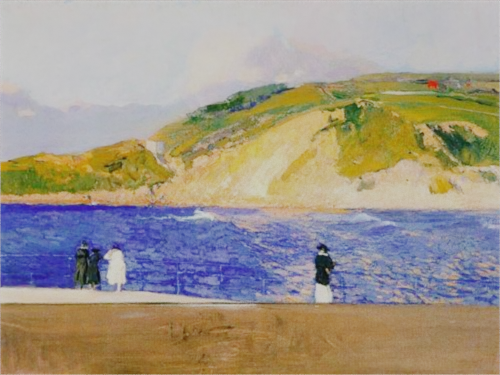

torch.Size([1, 375, 500, 4])



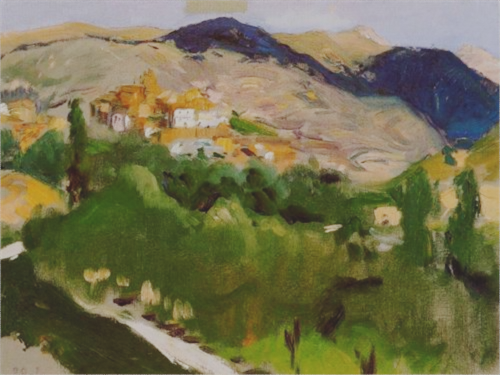

torch.Size([1, 504, 591, 4])



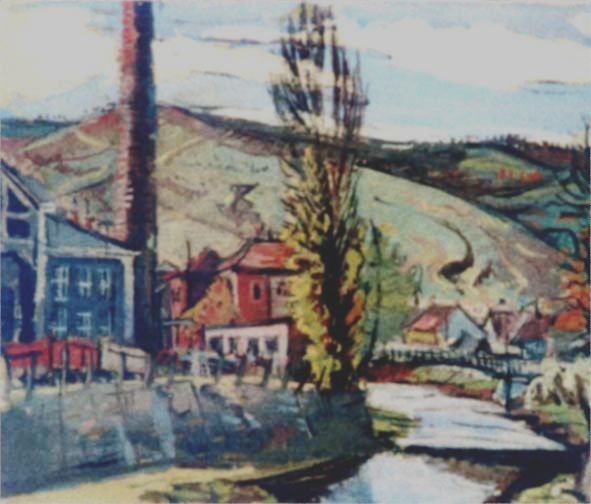

torch.Size([1, 345, 500, 4])



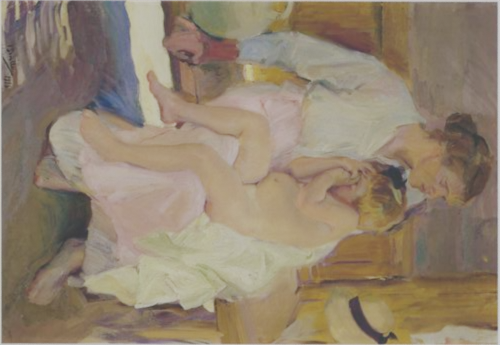

torch.Size([1, 333, 500, 4])



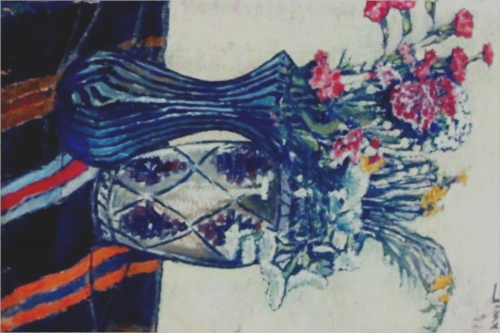

torch.Size([1, 320, 500, 4])



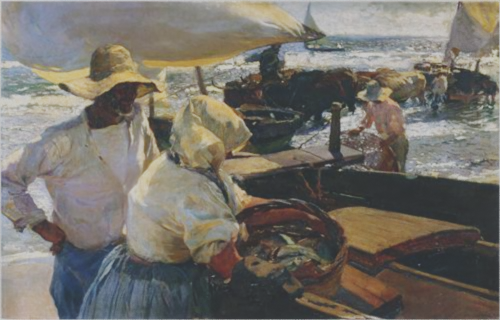

torch.Size([1, 606, 800, 4])



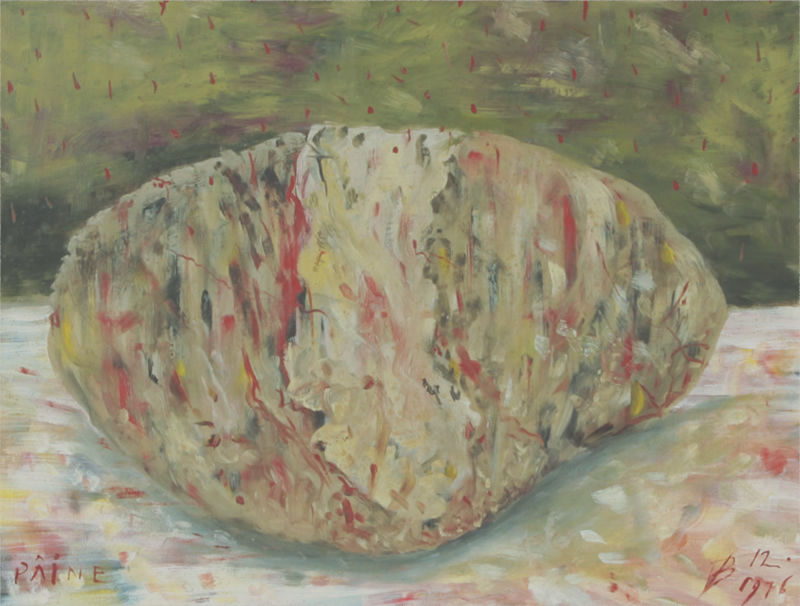

In [ ]:
import plotly.express as px

data_module = ImageDataModule('/content/data', 1)
trainloader = data_module.train_dataloader()
for images, label in trainloader:    # for testing, only works when batch size = 1
    print(label.shape)
    fig = px.imshow(label.squeeze())
    fig.show()